# 2018-12-03 - Améliorer la gestion de l'initialisation du réseau
Je soupçonne les 200 premières ms d'être a l'origine du crash, a cause de l'artéfact d'initialisation. Ce notebook de test retire les 200 premiers point du courant et les remplace par des 0.

Je diminue aussi de moitié la fréquence d'injection des courants

# Removing first steps in the array

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from LogGabor import LogGabor
import Spiking_LGN as SpiLGN
import datetime
from tqdm import tqdm

import pyNN.nest as sim
from pyNN.random import RandomDistribution as rnd
from pyNN.parameters import Sequence
from pyNN.utility import ProgressBar
from pyNN.utility.plotting import Figure, Panel

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


In [39]:
load_npz = np.load('./output/2018-12-20_08_40.npz') #what a great, descriptive filename
load_arr = load_npz['arr_0.npy']

In [40]:
test_arr = load_arr.copy()

print('Swapped array shape', test_arr.shape)
total_neurons = test_arr.shape[0] * test_arr.shape[1]
print('Total V1 Ring Neurons :', total_neurons)

Swapped array shape (12, 16, 2)
Total V1 Ring Neurons : 192


In [41]:
load_arr = None

In [42]:
test_arr = test_arr.tolist()

In [43]:
type(test_arr[0][0][0][0])

numpy.ndarray

In [48]:
del_time = 175

#que linus me pardonne d'avoir écrit un bloc aussi atroce
for orientations in test_arr:
    for positions in orientations:
        for onoff in positions:
            onoff = onoff.tolist()
            for filt in onoff:
                del filt[:del_time]
                filt.reverse()
                filt+=np.zeros(del_time).tolist()
                filt.reverse()

Text(0.5, 1.0, 'An example of removed start in filter')

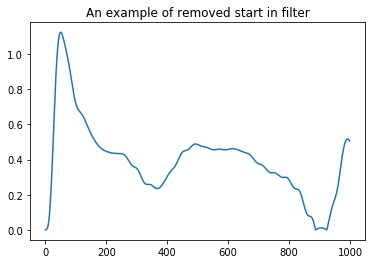

In [49]:
plt.plot(test_arr[0][0][0][0])
plt.title('An example of removed start in filter')

# Doing the simulation with lower frequency

In [50]:
##########
# Params #
##########
neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick #mV - McCormick
                    }
                
syn_params = {'sparseness' : .05, # U.Arb.
             'w' : .005, # siemens ?,
             'delay' : 2. #ms
             }
gain = .05
injection_sampling_rate = 5
total_time = 600

current_times = np.linspace(0,total_time,total_time/injection_sampling_rate)

/home/hugo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


The maximum input from the filters is :

In [51]:
plt.plot(np.max(np.max(test_arr), axis = 1), '.b')

ValueError: operands could not be broadcast together with shapes (19,1000) (30,1000) 

multiplied by the gain :

In [52]:
1. * gain

0.05

Each neuron has, on average :  

In [53]:
total_neurons * syn_params['sparseness']

9.600000000000001

lateral synapses. So if we want to have a non-noisy circuit, where lateral interactions have the same influence on the network, we'll use a synaptic weight of :

In [54]:
(1.*gain)/15

0.0033333333333333335

In [55]:
#############
# Simulation#
#############
sim.setup(timestep=0.1, threads = 8)

simple_cells = sim.Population(total_neurons, sim.IF_cond_alpha(**neuron_params),
                        initial_values={"v": neuron_params["v_reset"]}, label="simple_cells")
exc_exc_connexion = sim.Projection(simple_cells, simple_cells,
                                sim.FixedProbabilityConnector(syn_params['sparseness']
                                                              ,rng=sim.NumpyRNG(seed=42)), 
                                sim.StaticSynapse(weight=syn_params['w'], 
                                                  delay=syn_params['delay'])
                                )

neuron_iterator = 0

with tqdm(total = total_neurons, desc = 'LGN is communicating with V1') as progress_bar :
    for positions in test_arr: #WRONG VARIABLE NAME but it works the same nonetheless
        for orientations in positions :
            #injecting all ON LGN current
            for inputs in orientations[0]:
                current_level = inputs[::injection_sampling_rate]
                current_level = np.asarray(current_level)

                current_input = sim.StepCurrentSource(times = current_times,
                                                 amplitudes = current_level*gain)
                current_input.inject_into(simple_cells[neuron_iterator:neuron_iterator+1])
                current_input.record()
                
            #injecting all OFF LGN current
            for inputs in orientations[1]:
                current_level = inputs[::injection_sampling_rate]
                current_level = np.asarray(current_level)

                current_input = sim.StepCurrentSource(times = current_times,
                                                 amplitudes = current_level*gain)
                current_input.inject_into(simple_cells[neuron_iterator:neuron_iterator+1])
                current_input.record()
                
            #moving on to next V1 neuron 
            neuron_iterator +=1
            progress_bar.update(1)

LGN is communicating with V1: 100%|██████████| 192/192 [00:15<00:00, 11.57it/s]


In [56]:
simple_cells.record(['spikes', 'v'])
sim.run(total_time)
sim.end()

In [ ]:
v1_data = simple_cells.get_data().segments[0]
v1_voltage = v1_data.analogsignals[0]

In [ ]:
#NEO's arrays are weirdly shaped, we have to transpose them
fig, ax = plt.subplots(figsize = (16,10))
colors = plt.cm.autumn(np.linspace(.1, 1, 25))

neuron_iterator = 0
orientation = 3

for positions in test_arr[orientation]:
    index = neuron_iterator + (orientation * test_arr.shape[0]) #we're skipping the other positions

    ax.plot(v1_voltage.T[index],
            color=colors[neuron_iterator],
            alpha = 1)
        
    for spikes in np.asarray(v1_data.spiketrains[index]):
        plt.plot([ spikes*10,spikes*10 ] , [v1_voltage.T[index][int(spikes)] , 20],
        color=colors[neuron_iterator])

    neuron_iterator +=1


plt.title("Spikes for neurons preferring theta = %s" % ((np.pi/12)*3*180/np.pi))
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.Blues(np.linspace(.4, 1, 12))

neuron_iterator = 0
total_spikes, total_spiking_neurons = 0, 0


for i,orientations in enumerate(test_arr):
    for positions in orientations:
        ax.scatter(v1_data.spiketrains[neuron_iterator],
                   np.full_like(v1_data.spiketrains[neuron_iterator], neuron_iterator),
                   s=5, color=colors[i],
                   label='%.1f°' % (i*(np.pi/12)*180/np.pi) if neuron_iterator%25 ==0 else '')
        
        total_spikes += len(v1_data.spiketrains[neuron_iterator])
        if len(v1_data.spiketrains[neuron_iterator]) > 0:
            total_spiking_neurons += 1
            
        neuron_iterator += 1

plt.ylim(-5, total_neurons)
plt.xlim(150, total_time)

plt.ylabel('Neuron index')
plt.xlabel('Time (ms)')
handles, labels = ax.get_legend_handles_labels()
#handles[::-1], labels[::-1],
plt.legend(markerscale=3, title='Preferred orientation\n    for one position',
           ncol=2)

plt.title('''
            Mean population FR : %.2f Hz''' % (total_spikes/total_spiking_neurons))

#plt.savefig('./figs/2018_11_16_Ring_spikes_nosynapses_orientation.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')
plt.show()

In [ ]:
#we loop through the spiketrains and append those after the early onset discard phase
fr_list = []
for neuron_fr in v1_data.spiketrains :
    fr_list.append(np.where(neuron_fr>200))
    
print('Len fr list', len(fr_list))

#we split it in 12 orientations
k = np.split(np.asarray(fr_list),12)
len(k)

#faut bien s'amuser un peu dans les noms de variables
k_means = np.mean(k, axis = -1)
print('Means of K shape', k_means.shape)

In [ ]:
#for some reason numpy became retarded, so i have to use a retarded solution

mean_list = []
for means in k_means:
    _list = []
    for mean in means :
        _list.append(len(mean))
    mean_list.append(_list)
    
#well this was harder than expected    
final_array = np.mean(mean_list, axis = 1)

print('Final firing rate means', final_array)

In [ ]:
plt.figure(figsize = (8,6))

plt.xlabel('Orientation preference (°)')
plt.ylabel('Averaged sparse firing rate (hence the low level)')
plt.title('Sparse Network FR over %s ms\nStimulus at 60° with a bandwidth of 15°' % total_time)

#the two pis can be removed
plt.xticks(np.linspace(0,12,13), 
           np.round(np.linspace(0,12,12)/12*180, 1))

nbr_mc_vspan = 25
for vspan in range(nbr_mc_vspan) :
    plt.axvspan(2.7+vspan/nbr_mc_vspan,
               4.7-vspan/nbr_mc_vspan,
               color = 'blue', alpha = .05+vspan/(nbr_mc_vspan*15),
               label = 'Gradient of oriented input' if vspan == nbr_mc_vspan-1 else '')
plt.plot(final_array, color = 'black')
plt.scatter(np.linspace(0,12,12, endpoint = False), final_array, color = 'black')

plt.legend()

#plt.savefig('./figs/2018_11_23_Simple_ring_FR_MC.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')